In [2]:
#! pip install dask
#! pip install dask-ml
#! pip install bokeh
#! pip install bottleneck --upgrade
# ! pip install hvplot

In [3]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

## Check number of workers and cores running in your machine

In [4]:
print(client)

<Client: 'tcp://127.0.0.1:59100' processes=4 threads=16, memory=16.00 GiB>


In [6]:
sum(worker['nthreads'] for worker in client.scheduler_info()['workers'].values())

16

### Read data using DASK

In [7]:
%%time
ddf = dd.read_csv('data/Dask_MP_dataset.csv',dtype={'passenger_count': 'int64'})
ddf.head()

CPU times: user 149 ms, sys: 44.3 ms, total: 193 ms
Wall time: 2.44 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
from IPython.display import display
display(ddf.head())

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
print(ddf.npartitions)

3


In [10]:
print(ddf.dtypes)

Unnamed: 0                     int64
key                  string[pyarrow]
fare_amount                  float64
pickup_datetime      string[pyarrow]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
dtype: object


In [11]:
ddf.compute().shape

(2000000, 9)

In [12]:
# Dask DataFrame is split up into many pandas DataFrames. We sometimes call these “partitions”, and often the number of partitions is decided for you. 
print(ddf.npartitions)

3


### Read data using Pandas for comparison

In [14]:
%%time
df_pd = pd.read_csv('data/Dask_MP_dataset.csv')
df_pd.head()

CPU times: user 3.48 s, sys: 476 ms, total: 3.96 s
Wall time: 3.84 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Data cleaning

In [15]:
# Drop columns
columns_to_drop = ['Unnamed: 0', 'key']  # List of columns to drop
ddf = ddf.drop(columns_to_drop,axis=1)

In [16]:
# Drop duplicate rows
ddf = ddf.drop_duplicates()
#print(ddf.compute().shape)

In [17]:
# check number of partitions 
print(ddf.npartitions)

3


In [18]:
# drop NA rows
ddf = ddf.dropna()
print(ddf.compute().shape)

2024-06-07 17:05:24,759 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59114
2024-06-07 17:05:25,954 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760125.952493'


(1999983, 7)


In [19]:
# Define the bounding box for New York City
lat_min, lat_max = 40.5, 40.9
lon_min, lon_max = -74.25, -73.75

# Filter the DataFrame for pickup and dropoff points within the bounding box
ddf = ddf[(ddf['pickup_latitude'].between(lat_min, lat_max)) &
          (ddf['pickup_longitude'].between(lon_min, lon_max)) &
          (ddf['dropoff_latitude'].between(lat_min, lat_max)) &
          (ddf['dropoff_longitude'].between(lon_min, lon_max))]
print(ddf.compute().shape)

2024-06-07 17:05:30,549 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59114
2024-06-07 17:05:31,659 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760131.658349'


(1953959, 7)


## Feature engineering

In [20]:
# Extract day of the week, hour, month and year from pickup_datetime
ddf['pickup_datetime'] = ddf['pickup_datetime'].map_partitions(pd.to_datetime, meta=('pickup_datetime', 'datetime64[ns]'))

# Extract day of the week, hour, month, and year from 'pickup_datetime'
ddf['day_of_week'] = ddf['pickup_datetime'].map_partitions(lambda s: s.dt.dayofweek, meta=('day_of_week', 'int64'))
ddf['hour'] = ddf['pickup_datetime'].map_partitions(lambda s: s.dt.hour, meta=('hour', 'int64'))
ddf['month'] = ddf['pickup_datetime'].map_partitions(lambda s: s.dt.month, meta=('month', 'int64'))
ddf['year'] = ddf['pickup_datetime'].map_partitions(lambda s: s.dt.year, meta=('year', 'int64'))

# execute the operations and view results
result = ddf.compute()
print(result.head())

2024-06-07 17:05:36,523 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:05:37,327 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760137.3256729'


    fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
2           5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3           7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
6           7.5 2012-11-20 20:35:00+00:00        -73.980002        40.751662   
10          5.3 2012-04-08 07:30:50+00:00        -73.996335        40.737142   
13          7.0 2013-07-02 19:54:00+00:00        -74.005360        40.728867   

    dropoff_longitude  dropoff_latitude  passenger_count  day_of_week  hour  \
2          -73.991242         40.750562                2            3     0   
3          -73.991567         40.758092                1            5     4   
6          -73.973802         40.764842                1            1    20   
10         -73.980721         40.733559                1            6     7   
13         -74.008913         40.710907                1            1    19   

    month  year  
2       8  2011  
3       

In [21]:
# check datatypes now
#ddf.dtypes

In [22]:
# Convert degrees to radians for latitude and longitude
ddf['pickup_latitude_radians'] = np.radians(ddf['pickup_latitude'])
ddf['pickup_longitude_radians'] = np.radians(ddf['pickup_longitude'])
ddf['dropoff_latitude_radians'] = np.radians(ddf['dropoff_latitude'])
ddf['dropoff_longitude_radians'] = np.radians(ddf['dropoff_longitude'])

In [23]:
#print(ddf.head())

In [24]:
## function to calculate haversine distance (shortest distance between two points on a sphere using their latitudes and longitudes)
def haversine_distance(row):
    lat1, lon1, lat2, lon2 = row['pickup_latitude_radians'], row['pickup_longitude_radians'], row['dropoff_latitude_radians'], row['dropoff_longitude_radians']
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c  # Radius of Earth in kilometers. Use 3956 for miles
    return distance

In [25]:
# add the haversine distance to the dataframe
ddf['distance'] = ddf.map_partitions(lambda df: df.apply(haversine_distance, axis=1), meta=('distance', float))

In [26]:
print(ddf.head())

2024-06-07 17:05:49,218 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 61a355a720b043efdc953f239c83d943 initialized by task ('shuffle-transfer-61a355a720b043efdc953f239c83d943', 1) executed on worker tcp://127.0.0.1:59112
2024-06-07 17:05:49,779 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 61a355a720b043efdc953f239c83d943 deactivated due to stimulus 'task-finished-1717760149.778246'


    fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
2           5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3           7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
6           7.5 2012-11-20 20:35:00+00:00        -73.980002        40.751662   
10          5.3 2012-04-08 07:30:50+00:00        -73.996335        40.737142   
13          7.0 2013-07-02 19:54:00+00:00        -74.005360        40.728867   

    dropoff_longitude  dropoff_latitude  passenger_count  day_of_week  hour  \
2          -73.991242         40.750562                2            3     0   
3          -73.991567         40.758092                1            5     4   
6          -73.973802         40.764842                1            1    20   
10         -73.980721         40.733559                1            6     7   
13         -74.008913         40.710907                1            1    19   

    month  year  pickup_latitude_radians  pi

## Data exploration

2024-06-07 17:06:12,376 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 0) executed on worker tcp://127.0.0.1:59114
2024-06-07 17:06:13,541 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760173.539713'


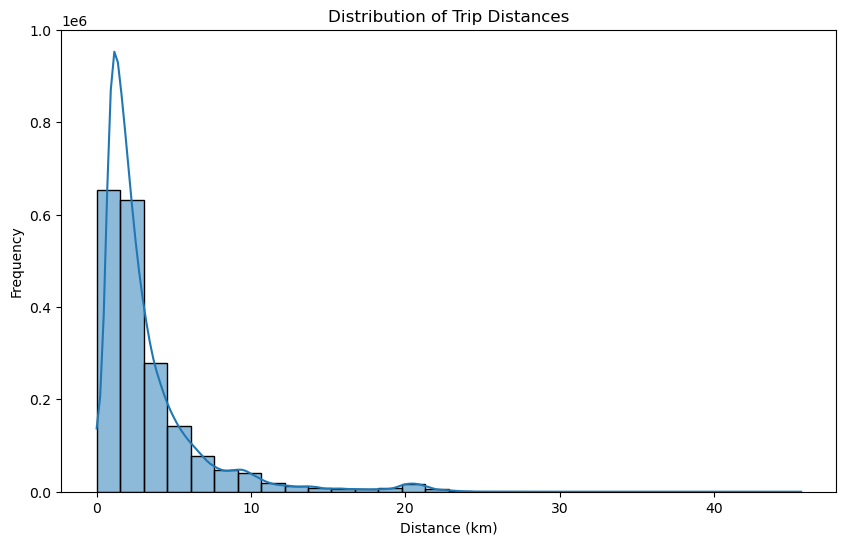

In [27]:
# Compute the result (this step might take time depending on your dataset size)
distance_data = ddf['distance'].compute()

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(distance_data, kde=True, bins=30)
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [28]:
#sns.boxplot(distance_data)

In [29]:
ddf['distance'].describe().compute()

2024-06-07 17:06:45,936 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59113
2024-06-07 17:06:46,789 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760206.788342'


count    1.953959e+06
mean     3.297195e+00
std      3.531603e+00
min      0.000000e+00
25%      1.254347e+00
50%      2.153299e+00
75%      3.908369e+00
max      4.564376e+01
Name: distance, dtype: float64

In [30]:
ddf.groupby("distance").distance.count().compute()

2024-06-07 17:07:11,782 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59112
2024-06-07 17:07:12,627 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760232.624616'


distance
0.000000     20133
0.000084         1
0.000084         1
0.000084         1
0.000084         1
             ...  
37.406180        1
38.326108        1
40.673014        1
43.235403        1
45.643764        1
Name: distance, Length: 1933589, dtype: int64

2024-06-07 17:07:37,291 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 0) executed on worker tcp://127.0.0.1:59113
2024-06-07 17:07:38,023 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760258.021781'


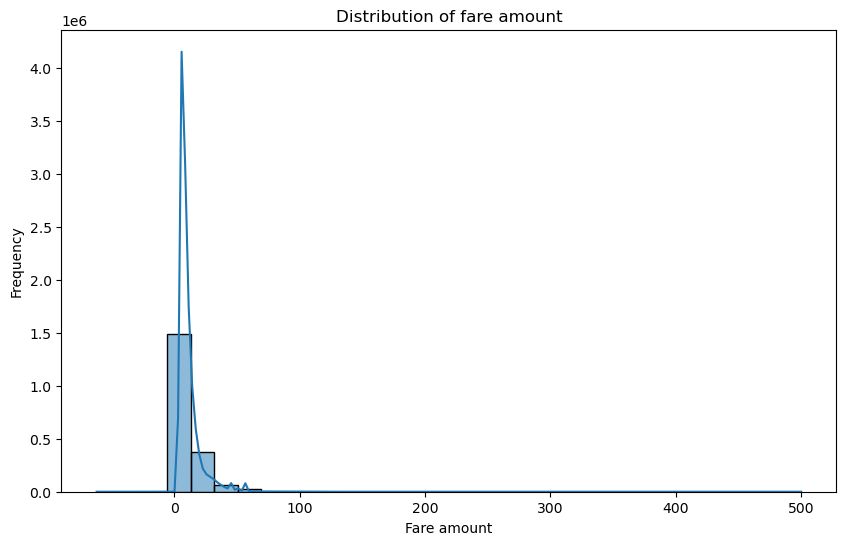

In [31]:
# Visualize the target - fare_amount
fare_amount_data = ddf['fare_amount'].compute()

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(fare_amount_data, kde=True, bins=30)
plt.title('Distribution of fare amount')
plt.xlabel('Fare amount')
plt.ylabel('Frequency')
plt.show()

In [32]:
ddf['fare_amount'].describe().compute()

2024-06-07 17:07:45,565 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59112
2024-06-07 17:07:46,388 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760266.3866298'


count    1.953959e+06
mean     1.126915e+01
std      9.444330e+00
min     -6.200000e+01
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      5.000000e+02
Name: fare_amount, dtype: float64

In [33]:
ddf.groupby("fare_amount").fare_amount.count().compute()

2024-06-07 17:07:49,525 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:07:50,319 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760270.3177128'


fare_amount
-52.00     1
-18.10     1
-10.10     1
-6.50      4
-6.00      1
          ..
 161.75    1
 180.33    1
 190.00    1
 255.00    1
 430.00    1
Name: fare_amount, Length: 2480, dtype: int64

In [34]:
#  Visualize it for a range of [0, 60]. 
filtered_ddf = ddf[ddf['fare_amount'].between(0, 60)]

2024-06-07 17:07:53,929 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59112
2024-06-07 17:07:54,850 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760274.8492548'


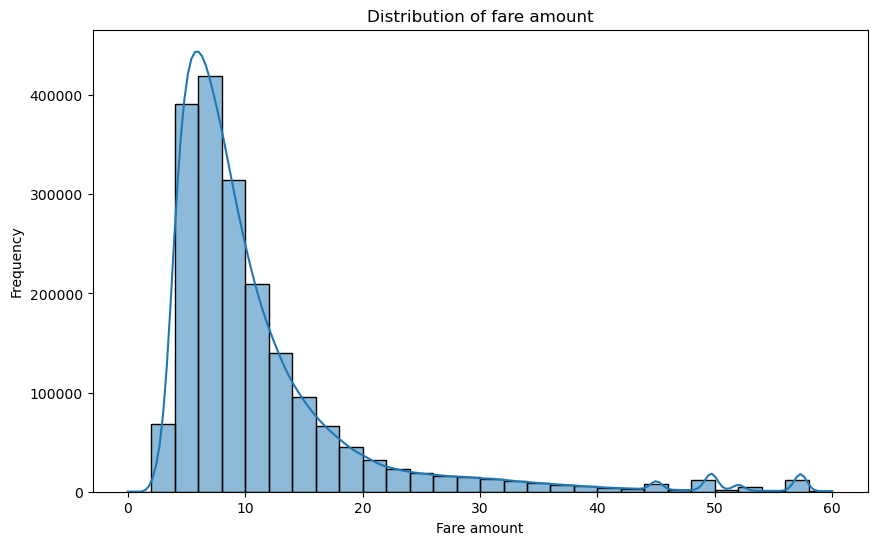

In [35]:
fare_amount_data = filtered_ddf['fare_amount'].compute()

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(fare_amount_data, kde=True, bins=30)
plt.title('Distribution of fare amount')
plt.xlabel('Fare amount')
plt.ylabel('Frequency')
plt.show()

## Bi-variates

2024-06-07 17:08:04,474 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 2) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:08:05,315 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760285.3136709'


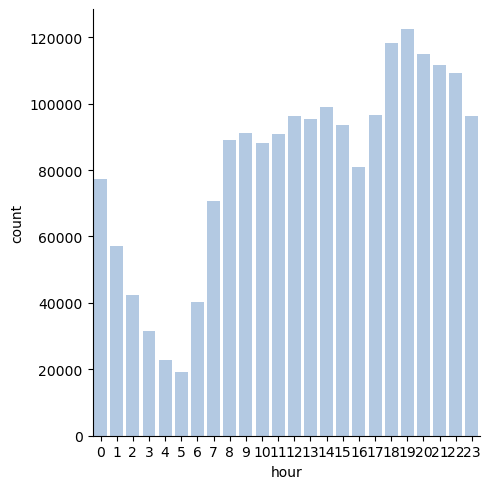

In [36]:
# Plot the taxi trips by hour of the day
hourly_trip_counts = ddf.groupby('hour').size().compute()
hourly_trip_counts_df = hourly_trip_counts.reset_index()
hourly_trip_counts_df.columns = ['hour', 'count']
sns.catplot(x='hour', y='count', kind= 'bar',data=hourly_trip_counts_df,color= '#abc9ea')
plt.show()

2024-06-07 17:08:15,710 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 2) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:08:16,681 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760296.678986'


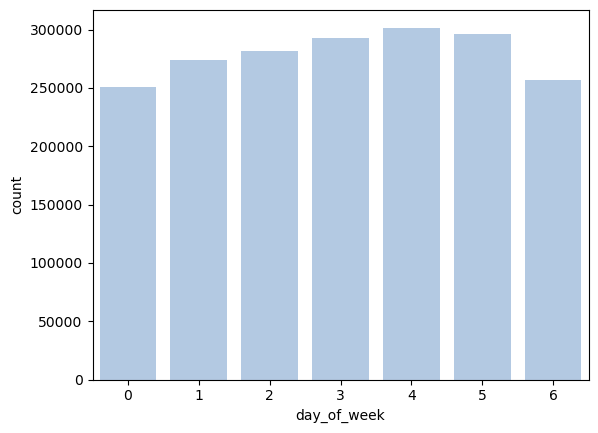

In [37]:
# Plot the taxi trips by day of the week
day_of_week_trip_counts = ddf.groupby('day_of_week').size().compute()
day_of_week_trip_counts_df = day_of_week_trip_counts.reset_index()
day_of_week_trip_counts_df.columns = ['day_of_week', 'count']
sns.barplot(x='day_of_week', y='count', data=day_of_week_trip_counts_df,color= '#abc9ea')
plt.show()

2024-06-07 17:08:26,909 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 2) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:08:27,719 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760307.717707'


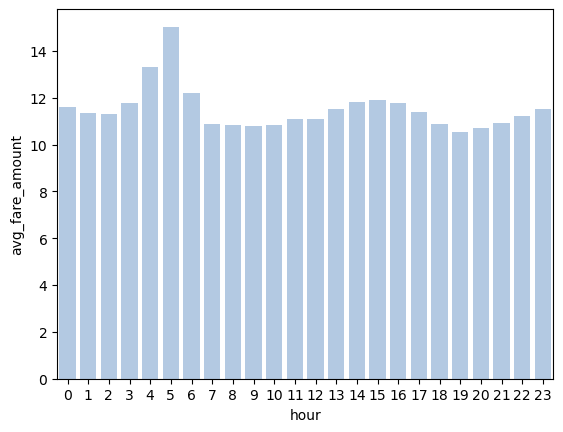

In [38]:
# plot average fare_amount by hour
fare_by_hour = ddf.groupby('hour')['fare_amount'].mean().compute()
fare_by_hour_df = fare_by_hour.reset_index()
fare_by_hour_df.columns = ['hour', 'avg_fare_amount']
sns.barplot(x='hour', y='avg_fare_amount', data=fare_by_hour_df,color= '#abc9ea')
plt.show()

2024-06-07 17:08:39,387 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59114
2024-06-07 17:08:40,360 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760320.3586922'


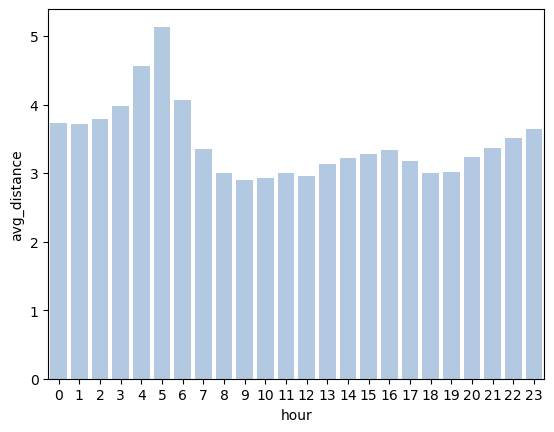

In [39]:
# plot average distance by hour
dist_by_hour = ddf.groupby('hour')['distance'].mean().compute()
dist_by_hour_df = dist_by_hour.reset_index()
dist_by_hour_df.columns = ['hour', 'avg_distance']
sns.barplot(x='hour', y='avg_distance', data=dist_by_hour_df,color= '#abc9ea')
plt.show()

2024-06-07 17:09:03,902 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:09:04,789 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760344.788295'


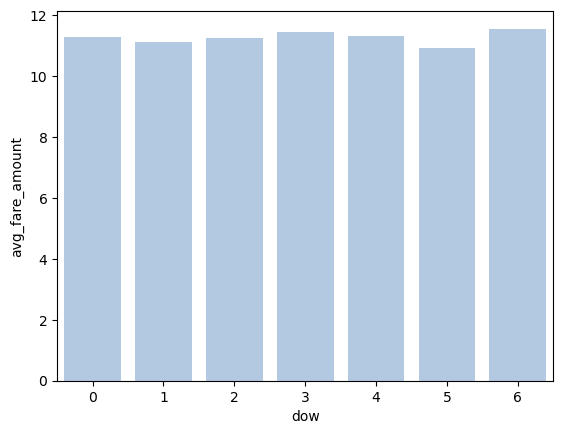

In [40]:
# plot average fare_amount by day of week
fare_by_dow = ddf.groupby('day_of_week')['fare_amount'].mean().compute()
fare_by_dow_df = fare_by_dow.reset_index()
fare_by_dow_df.columns = ['dow', 'avg_fare_amount']
sns.barplot(x='dow', y='avg_fare_amount', data=fare_by_dow_df,color= '#abc9ea')
plt.show()

In [41]:
# create a subset of the Dask DataFrame
df_sample = ddf.sample(frac=0.1).compute()

2024-06-07 17:09:16,841 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 2) executed on worker tcp://127.0.0.1:59111
2024-06-07 17:09:17,647 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760357.645849'


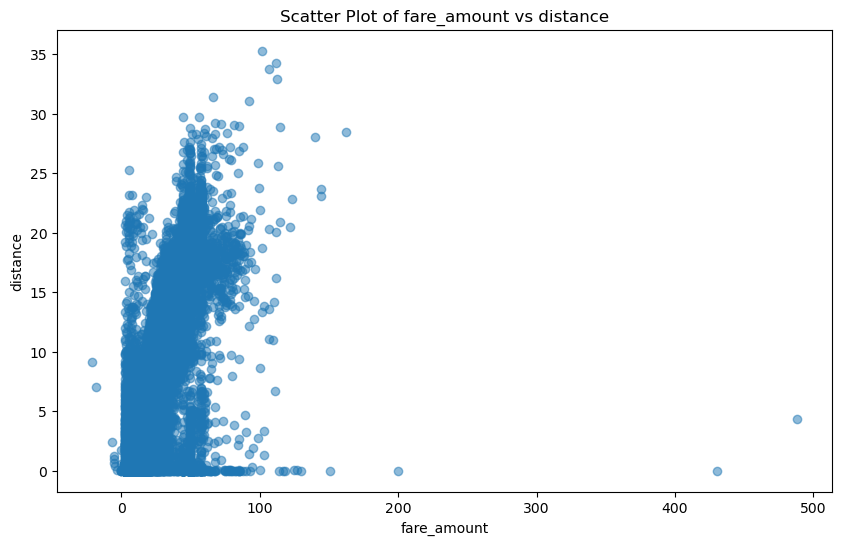

In [44]:
# Create the scatter plot between fare amount and distance
plt.figure(figsize=(10, 6))
plt.scatter(df_sample['fare_amount'], df_sample['distance'], alpha=0.5)
plt.xlabel('fare_amount')
plt.ylabel('distance')
plt.title(f'Scatter Plot of fare_amount vs distance')
plt.show()

In [45]:
# Clean the data by removing outliers
ddf_model = ddf[(ddf['fare_amount'] > 0) & (ddf['fare_amount'] < 60) & (ddf['distance'] > 0)]

ddf_model.compute().shape

2024-06-07 17:12:22,954 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59112
2024-06-07 17:12:23,798 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760543.796725'


(1929460, 16)

## Check correlation between fare amount and distance

In [46]:
# Calculate the correlation coefficient
correlation = ddf_model[['fare_amount', 'distance']].corr().compute()
# Print the entire correlation matrix
print(correlation)

2024-06-07 17:12:49,248 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59113
2024-06-07 17:12:50,050 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760570.048876'


             fare_amount  distance
fare_amount     1.000000  0.895444
distance        0.895444  1.000000


## Build a prediction model for fare amount

In [47]:
# Define the target variable
y = ddf_model['fare_amount']

# Define predictor
X = ddf_model[['distance']]

In [48]:
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
# Compute the train and test sets
X_train, X_test = X_train.compute(), X_test.compute()
y_train, y_test = y_train.compute(), y_test.compute()

2024-06-07 17:13:14,312 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59113
2024-06-07 17:13:15,306 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760595.304818'
2024-06-07 17:13:39,480 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c82023a91bf21666b259c', 1) executed on worker tcp://127.0.0.1:59114
2024-06-07 17:13:40,421 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c deactivated due to stimulus 'task-finished-1717760620.420108'
2024-06-07 17:14:04,598 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5abd2df9548c82023a91bf21666b259c initialized by task ('shuffle-transfer-5abd2df9548c8202

In [50]:
# Convert to arrays as dask's .fit() function takes array as attribute
X_train, X_test = X_train.values, X_test.values
y_train, y_test = y_train.values, y_test.values

In [51]:
# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [52]:
## Make predictions on test data
y_pred = model.predict(X_test)

In [54]:
# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 15.477273090207262
R2 Score: 0.8017161948416611


In [55]:
# check if the model performs than a baseline prediction
y_mean_pred = da.mean(y_test).compute()
y_baseline_pred = da.full_like(y_test, y_mean_pred).compute()

In [56]:
# Calculate mean squared error
mse = mean_squared_error(y_test, y_baseline_pred)

# Calculate R2 score
r2 = r2_score(y_test, y_baseline_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 78.05616337576302
R2 Score: 0.0
